## Cold Fusion Working Book

In [ ]:
# Get ASO Depth

In [7]:
# standard imports
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt 
import datetime

# some mapping widgets
import ipyleaflet
from ipyleaflet import Map, GeoData, Rectangle, basemaps, LayersControl, basemap_to_tiles, TileLayer, SplitMapControl, Polygon, MagnifyingGlass
import ipywidgets

# database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas, query_to_pandas
from snowexsql.db import get_table_attributes

from sqlalchemy.sql import func
from geoalchemy2.types import Raster

In [8]:
# load the database
db_name = 'snow:hackweek@db.snowexdata.org/snowex'
engine, session = get_db(db_name)

print('SnowEx Database successfully loaded!')

SnowEx Database successfully loaded!


In [9]:
import shapely.geometry

In [10]:
bbox_WSEN = 742000, 4322000, 747000, 4325000
x1, y1, x2, y2 = bbox_WSEN
Polygon()

polygon = shapely.geometry.Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])

In [23]:
# Retrieve some of the ASO Snow Depth tiles
query = session.query(func.ST_AsTiff(ImageData.raster))
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "swe")
query = query.filter(ImageData.date == "2020-02-02")
result = query.count()
print(result)

2


/tmp/ipykernel_5100/4202596894.py:6: SAWarning: UserDefinedType Raster() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  result = query.count()


In [11]:
# Retrieve some of the ASO Snow Depth tiles
query = session.query(func.ST_AsTiff(ImageData.raster))
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "swe")
query = query.filter(ImageData.date == "2020-02-02")
result = query.limit(10)
print(result)

SELECT ST_AsTiff(public.images.raster) AS "ST_AsTiff_1" 
FROM public.images 
WHERE public.images.observers = %(observers_1)s AND public.images.type = %(type_1)s AND public.images.date = %(date_1)s 
 LIMIT %(param_1)s


In [24]:
result.all()

AttributeError: 'int' object has no attribute 'all'

In [25]:
from snowexsql.conversions import raster_to_rasterio

In [26]:
datasets = raster_to_rasterio(session, result)
for dataset in datasets:
    print('Raster {} X {}, Final Res = {} x {}'.format(dataset.width, dataset.height, dataset.res[0], dataset.res[1]))
    print(dataset.bounds)

TypeError: 'int' object is not iterable

In [28]:
import shapely.geometry
from geoalchemy2.shape import from_shape
import geoalchemy2.functions as gfunc

bbox_WSEN = 742000, 4322000, 747000, 4325000
x1, y1, x2, y2 = bbox_WSEN
polygon = shapely.geometry.Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]]) # used box() before
wkb_element = from_shape(polygon, srid=32612) # which srid is right?
# Retrieve some of the ASO Snow Depth tiles
query = session.query(func.ST_AsTiff(ImageData.raster))
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "swe")
query = query.filter(ImageData.date == "2020-02-02")

# Filter the query by bounding box
query = query.filter(gfunc.ST_Intersects(ImageData.raster, wkb_element))

result = query.count()
print(result)

/tmp/ipykernel_5100/2391775975.py:18: SAWarning: UserDefinedType Raster() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  result = query.count()


InternalError: (psycopg2.errors.InFailedSqlTransaction) current transaction is aborted, commands ignored until end of transaction block

[SQL: SELECT count(*) AS count_1 
FROM (SELECT ST_AsTiff(public.images.raster) AS "ST_AsTiff_1" 
FROM public.images 
WHERE public.images.observers = %(observers_1)s AND public.images.type = %(type_1)s AND public.images.date = %(date_1)s AND ST_Intersects(public.images.raster, ST_GeomFromWKB(%(ST_GeomFromWKB_1)s, %(ST_GeomFromWKB_2)s))) AS anon_1]
[parameters: {'observers_1': 'ASO Inc.', 'type_1': 'swe', 'date_1': '2020-02-02', 'ST_GeomFromWKB_1': <memory at 0x7f21d4dbba00>, 'ST_GeomFromWKB_2': 32612}]
(Background on this error at: https://sqlalche.me/e/14/2j85)

In [29]:
from geoalchemy2.shape import from_shape
import geoalchemy2.functions as gfunc

In [30]:
wkb_element = from_shape(polygon, srid=26912) # not 32612
print(type(wkb_element))
print(type(wkb_element.ST_AsEWKT()))

<class 'geoalchemy2.elements.WKBElement'>
<class 'geoalchemy2.functions.ST_AsEWKT'>


In [31]:
session.rollback()

In [32]:
# Retrieve some of the ASO Snow Depth tiles
# https://snowexsql.readthedocs.io/en/latest/gallery/raster_union_and_more_example.html
query = session.query(func.ST_AsTiff(func.ST_Clip(func.ST_Union(ImageData.raster, type_=Raster), wkb_element)))
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "swe")
query = query.filter(ImageData.date == "2020-02-02")

# Filter the query by bounding box
query = query.filter(gfunc.ST_Intersects(ImageData.raster, wkb_element))

result = query.all()
print(result)

aso_2020_02_02_SWE_raster = raster_to_rasterio(session, result)[0].read(1, masked=True)

[(<memory at 0x7f21d4a4b640>,)]


In [33]:
datasets = raster_to_rasterio(session, result)
areas = []
for dataset in datasets:
    # print('Raster {} X {}, Final Res = {} x {}'.format(dataset.width, dataset.height, dataset.res[0], dataset.res[1]))
    # print(dataset.bounds)
    area = dataset.width * dataset.height * dataset.res[0] * dataset.res[1]
    areas.append(area)
    

In [34]:
sum(areas) # area in m^2 of all the rasters. We need to actually clip them and merge them as 1 raster


15402562.281070676

In [35]:
datasets[0]

<open DatasetReader name='/vsimem/7dbbf73f-3026-466c-ad79-1285fd9a2bbe/7dbbf73f-3026-466c-ad79-1285fd9a2bbe.tif' mode='r'>

In [36]:
aso_2020_02_02_SWE_raster

masked_array(
  data=[[--, 0.22746525704860687, 0.23084796965122223, ...,
         0.26724734902381897, 0.27874913811683655, 0.22820797562599182],
        [--, 0.23704922199249268, 0.2167941778898239, ...,
         0.24958686530590057, 0.3043063282966614, 0.3039507269859314],
        [--, 0.23924744129180908, 0.22757886350154877, ...,
         0.26188695430755615, 0.23975682258605957, 0.26511794328689575],
        ...,
        [--, 0.2106463462114334, 0.21497678756713867, ...,
         0.26460549235343933, 0.26317304372787476, 0.26337528228759766],
        [--, 0.2048443704843521, 0.21319454908370972, ...,
         0.26276034116744995, 0.261733740568161, 0.2579173743724823],
        [--, --, --, ..., --, --, --]],
  mask=[[ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        ...,
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., 

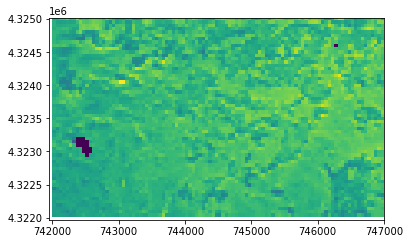

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 432x288 with 0 Axes>

In [37]:
from rasterio.plot import show
import matplotlib.pyplot as plt
aso_2020_02_02_SWE_raster = dataset.read(1)
img = show(aso_2020_02_02_SWE_raster, transform=dataset.transform)#, cmap='terrain')
plt.colorbar()

In [38]:
aso_2020_02_02_SWE_raster.min()

nan

In [39]:
40*256*256*3*3 / (1000*1000) # how much area our tiles 
# our bbox is 3000 x 5000 m

23.59296

In [40]:
get_table_attributes(ImageData)

['date',
 'date_accessed',
 'description',
 'doi',
 'instrument',
 'metadata',
 'observers',
 'raster',
 'registry',
 'site_name',
 'time_created',
 'time_updated',
 'type',
 'units']

In [41]:
# Retrieve some of the ASO Snow Depth tiles
query = session.query(func.ST_AsTiff(ImageData.raster))
query = query.filter(ImageData.surveyors == "ASO Inc.")
query = query.filter(ImageData.type == "swe")
query = query.filter(ImageData.date == "2020-02-02")
result = query.count()
print(result)

AttributeError: type object 'ImageData' has no attribute 'surveyors'

In [25]:
# How to pull out ALL point data from the database that falls within our box
bbox_WSEN = 742000, 4322000, 747000, 4325000 # EPSG 26912?
x1, y1, x2, y2 = bbox_WSEN
polygon = shapely.geometry.Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]]) # used box() before
wkb_element = from_shape(polygon, srid=26912) # which srid is right?

query = session.query(PointData)
# We need to filter

# Filter the query by bounding box (the part that doesn't work)
query = query.filter(gfunc.ST_Within(PointData.geom, wkb_element))

result = query.count()
print(result)

/tmp/ipykernel_5033/1958901626.py:13: SAWarning: Class ST_Within will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  result = query.count()


4679570


## Second LIDAR Dataset

In [42]:
dataset

<open DatasetReader name='/vsimem/7dbbf73f-3026-466c-ad79-1285fd9a2bbe/7dbbf73f-3026-466c-ad79-1285fd9a2bbe.tif' mode='r'>

In [43]:
# Retrieve some of the ASO Snow Depth tiles
# https://snowexsql.readthedocs.io/en/latest/gallery/raster_union_and_more_example.html
query = session.query(func.ST_AsTiff(func.ST_Clip(func.ST_Union(ImageData.raster, type_=Raster), wkb_element)))
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "swe")
query = query.filter(ImageData.date == "2020-02-13")

# Filter the query by bounding box
query = query.filter(gfunc.ST_Intersects(ImageData.raster, wkb_element))

result = query.all()
print(result)

aso_2020_02_13_SWE_raster = raster_to_rasterio(session, result)[0].read(1, masked=True)

[(<memory at 0x7f21cc09f1c0>,)]


In [44]:
assert len(result) == 1, "should have just 1 merged raster"
datasets = raster_to_rasterio(session, result)
dataset = datasets[0]

import rioxarray
aso_2020_02_13_SWE_raster = rioxarray.open_rasterio(dataset)#.read(1)
# img = show(aso_2020_02_13_raster, transform=dataset.transform)#, cmap='terrain')
# plt.colorbar()

RasterioIOError: No such file or directory

In [46]:
import numpy as np
aso_2020_02_13_SWE_raster[aso_2020_02_13_SWE_raster == -9999] = np.nan
aso_2020_02_02_SWE_raster[aso_2020_02_02_SWE_raster == -9999] = np.nan
# show(aso_2020_02_13_SWE_raster - aso_2020_02_02_DEPTH_raster)
print(np.nanmin(aso_2020_02_13_SWE_raster), np.nanmax(aso_2020_02_13_SWE_raster))
print(np.nanmin(aso_2020_02_02_SWE_raster), np.nanmax(aso_2020_02_02_SWE_raster))

0.0 0.42033902
0.0 0.37323296


In [47]:
type(diff)

NameError: name 'diff' is not defined

In [48]:
plt.hist(diff)

NameError: name 'diff' is not defined

In [49]:
import ipyleaflet
from ipyleaflet import Map, Rectangle, basemaps, basemap_to_tiles, TileLayer, SplitMapControl, Polygon
from ipyleaflet import GeoData, LayersControl

m = Map(zoom=6)

right_layer = basemap_to_tiles(basemaps.NASAGIBS.ModisTerraTrueColorCR, "2019-04-25")
left_layer = TileLayer()
control = SplitMapControl(left_layer=left_layer, right_layer=right_layer)
m.add_control(control)
m.add_layer(GeoData(geo_dataframe=gdf))
# m.add_layer(rectangle)

m

NameError: name 'gdf' is not defined

Range of changes in the (meters) -0.050078556 0.06832343


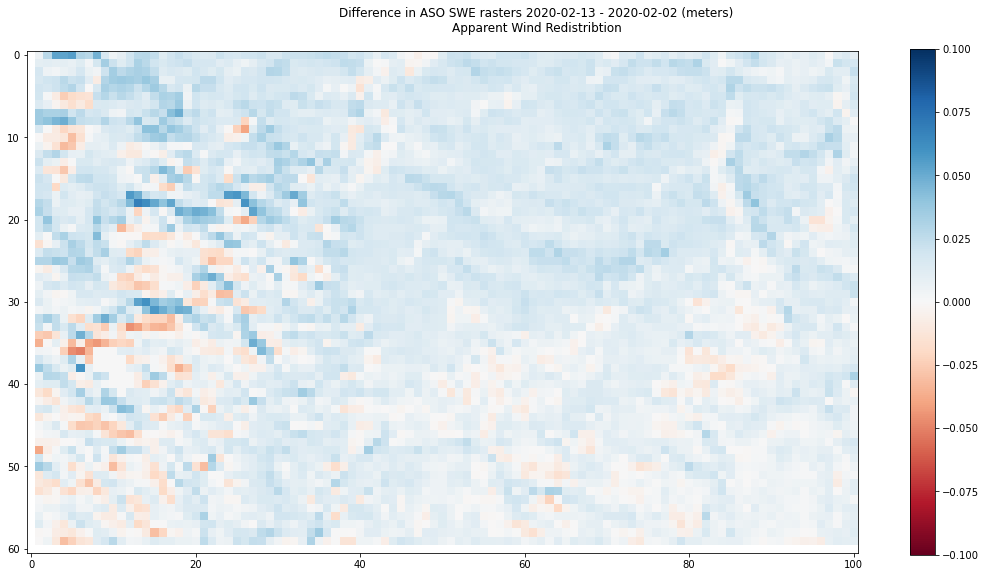

In [63]:
# Redo with rioxarray so we don't lose the coordinate information
fig, ax = plt.subplots(figsize=(15,8))
diff = aso_2020_02_13_SWE_raster - aso_2020_02_02_SWE_raster

print("Range of changes in the (meters)", np.nanmin(diff), np.nanmax(diff))
#show(diff, ax=ax, cmap="RdBu")
data=ax.imshow(diff, cmap="RdBu", vmax=0.1, vmin=-0.1)
fig.suptitle("Difference in ASO SWE rasters 2020-02-13 - 2020-02-02 (meters)\nApparent Wind Redistribtion")


fig.colorbar(data, ax=ax)
plt.tight_layout()
# Got a lot of GPR data where the drifting happened